In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re
import nltk
import operator
import numpy as np
import pandas as pd
from math import log
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# amazon = pd.read_csv('/content/drive/My Drive/amazon_reviews.csv')
binary_airline = pd.read_csv('/content/drive/My Drive/binary_air_review.csv')
# binary_hotel = pd.read_csv('/content/drive/My Drive/hotel-reviews.csv')
# clothing = pd.read_csv('/content/drive/My Drive/clothing.csv')
# movie = pd.read_csv('/content/drive/My Drive/train.csv')
# steam = pd.read_csv('/content/drive/My Drive/steam.csv')
# yelp = pd.read_csv('/content/drive/My Drive/yelp.csv')

In [4]:
# sorting = amazon.sort_values(['label'])                     ## contents
sorting = binary_airline.sort_values(['rating'])            ## comment
# sorting = binary_hotel.sort_values(['Is_Response'])         ## Description
# sorting = clothing.sort_values(['Recommended IND'])         ## Review Text
# sorting = movie.sort_values(['sentiment'])                  ## text
# sorting = steam.sort_values(['user_suggestion'])            ## user_review
# sorting = yelp.sort_values(['rating'])                      ## review

In [5]:
sorting

,Unnamed: 0,comment,rating
0,0,Good customer service thejith. Dealing with cu...,0
24897,24897,I have used WallyPark several times with very ...,0
24898,24898,Very happy and pleased with experience at Wall...,0
24899,24899,Will not park anywhere else! Quality of servic...,0
24900,24900,"Quality and service has fallen off, plus ended...",0
...,...,...,...
49776,103536,This was our first and last experience with Wa...,1
49777,103537,Had some really bad experiences: 1) Was LIED t...,1
49778,103538,Excellent service and excellent products! When...,1
49798,103558,Booked 3 rooms and was sent a misleading email...,1


In [53]:
a=pd.DataFrame(index=range(0,1), columns=['score', 'a'])

a.iloc[0,0] = 1
a.iloc[0,1] = 2

In [6]:
## 본문부분 열 이름과 점수부분 열 이름 입력

contents_name = "comment"
label_name = "rating"

In [7]:
def data_loading(sorting, contents_name, label_name):

  review_ = sorting.reset_index()
  # 라벨 인코더 생성
  encoder = LabelEncoder()

  # X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
  encoder.fit(review_[label_name])
  target_encoded = encoder.transform(review_[label_name])

  contents = list(np.array(review_[contents_name].tolist()))
  label = list(target_encoded)
  cnts_N = contents[:2000]+contents[-2000:]   ## X_train
  label_N = label[:2000]+label[-2000:]        ## y_train

  ## train data를 제외한 test data
  test_dict = {'document':contents[2000:-2000],"label":label[2000:-2000]}
  test_df = pd.DataFrame(test_dict)

  np.random.seed(0)

  df_shuffled=test_df.iloc[np.random.permutation(test_df.index)].reset_index(drop=True)
  df_shuffled

  tdata = df_shuffled['document']
  tlabel = df_shuffled['label']

  return cnts_N, label_N, tdata, tlabel

In [8]:
## train test split과 같이 진행

train_X, train_Y, test_X, test_Y = data_loading(sorting, contents_name, label_name)

In [9]:
def preprocessing(data):

    from nltk import FreqDist
    from nltk.stem.snowball import SnowballStemmer
    snowball = SnowballStemmer('english')

    #print("문자외에 다른요소 제거중....")
    normalized_text = []  ## 괄호 제거 및 문자이외의 데이터 제거
    for scr in data:
        scr = re.sub('\(', ' ', scr)
        scr = re.sub('\)', ' ', scr)
        scr = re.sub('[^ a-zA-Zㄱ-힗]', '', scr)
        normalized_text.append(scr.lower())

    #print("토큰화중....")
    result = [word_tokenize(sentence) for sentence in normalized_text]  ## 토큰화

    ## 단어 빈도 수 계산( 10번이상 등장하지 않는 단어 stopword에 포함 )
    vocab = list(set(w for i in result for w in i))
    vocab.sort()

    check_freq = []
    for line in result:
        for wd in line:
            check_freq.append(wd)

    fdist = FreqDist(check_freq)

    low_freq = []
    for i in vocab:
        if fdist[i] < 10:
            low_freq.append(i)

    stop_words = set(stopwords.words('english'))
    stop_words = list(stop_words)
    for i in low_freq:
        stop_words.append(i)

    ## stopwords 제거 및 stemming
    #print("불용어 제거중....")
    except_stopword = []
    for st in result:
        temp = []
        for tk in st:
            if tk not in stop_words:
                temp.append(snowball.stem(tk))
        except_stopword.append(temp)
    #print("끝!")
    
    return except_stopword

In [10]:
## train data 토큰화

train_tokens = preprocessing(train_X)

리뷰의 최대 길이 : 358
리뷰의 평균 길이 : 23.90825


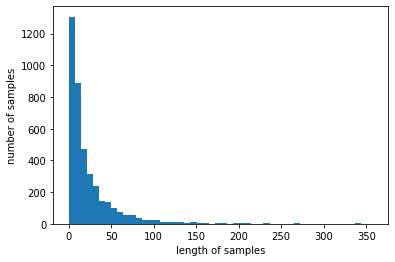

In [11]:
print('리뷰의 최대 길이 :',max(len(l) for l in train_tokens))
print('리뷰의 평균 길이 :',sum(map(len, train_tokens))/len(train_tokens))
plt.hist([len(s) for s in train_tokens], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [12]:
vocab = list(set(w for i in train_tokens for w in i ))
vocab.sort()

In [13]:
print('단어의 갯수는 총 %d개 이다'%(len(vocab)))

1146

In [14]:
## 전처리 된 단어들을 다시 문장화

def corpus(tokens):
  corp = []
  for sent in tokens:
    tmp = " ".join(sent)
    corp.append(tmp)

  return corp

train_corp = corpus(train_tokens)

# SHAP

In [15]:
!pip install shap

     |████████████████████████████████| 358kB 6.9MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp37-cp37m-linux_x86_64.whl size=490494 sha256=a9be6c320405f7df1e1669dd3d75ece0acd4a1ecd348bafc60cfeceeb2443f6e
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


# Linear

In [16]:
import shap
import sklearn
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

먼저 TF-IDF로 vectorize한 행렬을 Logisitic Regression으로 학습

In [29]:
corpus_train, corpus_test, y_train, y_test = train_test_split(train_corp, train_Y, test_size=0.4, random_state=7)

vectorizer = TfidfVectorizer(min_df=50)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

In [30]:
lrmodel = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
lrmodel.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
lexplainer = shap.LinearExplainer(lrmodel, X_train, feature_dependence="independent")
shap_values = lexplainer.shap_values(X_test)
X_test_array = X_test.toarray() # we need to pass a dense version for the plotting functions

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


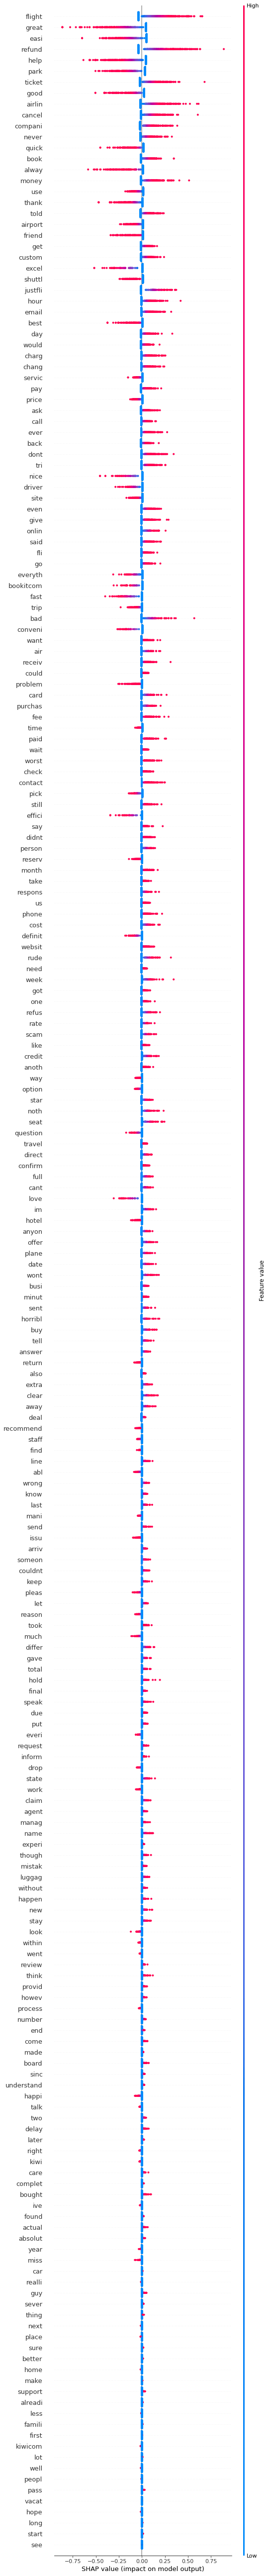

In [32]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names(), max_display=500)

In [33]:
linear_frame = pd.DataFrame(shap_values, columns=vectorizer.get_feature_names())
linear_frame

,abl,absolut,actual,agent,air,airlin,airport,alreadi,also,alway,anoth,answer,anyon,arriv,ask,away,back,bad,best,better,board,book,bookitcom,bought,busi,buy,call,cancel,cant,car,card,care,chang,charg,check,claim,clear,come,compani,complet,...,state,stay,still,support,sure,take,talk,tell,thank,thing,think,though,ticket,time,told,took,total,travel,tri,trip,two,understand,us,use,vacat,wait,want,way,websit,week,well,went,within,without,wont,work,worst,would,wrong,year
0,0.00098,-0.000325,-0.000135,-0.000659,-0.005648,-0.014703,0.011783,-0.000196,-0.001926,0.011054,-0.002195,-0.001646,-0.002004,-0.001301,-0.008038,-0.000782,-0.007843,0.178477,0.006846,-0.000207,-0.00023,-0.011543,0.005539,0.0,-0.002063,-0.001038,-0.006698,0.135534,-0.001857,-0.000387,-0.004143,-0.000132,-0.006717,-0.006029,-0.003939,-0.000481,-0.000555,-0.000251,-0.018152,-0.000543,...,-0.000435,-0.000188,-0.003094,0.0,-0.000198,-0.004377,0.000505,-0.001424,0.008205,-0.000244,-0.00027,-0.000464,-0.022241,0.004689,-0.013495,0.000000,-0.000801,-0.002296,-0.003796,0.003152,-0.000056,-0.000561,-0.003364,0.014828,-0.000056,-0.004940,-0.004633,0.002849,-0.001988,0.110914,0.000052,0.000855,0.000529,-0.000562,-0.001294,0.000586,-0.002987,-0.008558,-0.001406,0.000166
1,0.00098,-0.000325,-0.000135,-0.000659,-0.005648,-0.014703,0.011783,-0.000196,-0.001926,0.011054,-0.002195,-0.001646,-0.002004,-0.001301,-0.008038,-0.000782,-0.007843,-0.002371,0.006846,-0.000207,-0.00023,-0.011543,0.005539,0.0,-0.002063,-0.001038,-0.006698,-0.008971,-0.001857,-0.000387,-0.004143,-0.000132,-0.006717,-0.006029,-0.003939,-0.000481,-0.000555,-0.000251,-0.018152,-0.000543,...,-0.000435,-0.000188,-0.003094,0.0,-0.000198,-0.004377,0.000505,-0.001424,0.008205,-0.000244,-0.00027,-0.000464,-0.022241,0.004689,-0.013495,0.000000,-0.000801,-0.002296,-0.003796,0.003152,-0.000056,-0.000561,-0.003364,0.014828,-0.000056,-0.004940,-0.004633,0.002849,-0.001988,-0.001326,0.000052,0.000855,0.000529,-0.000562,-0.001294,0.000586,-0.002987,-0.008558,-0.001406,0.000166
2,0.00098,-0.000325,-0.000135,-0.000659,-0.005648,-0.014703,0.011783,-0.000196,-0.001926,0.011054,-0.002195,-0.001646,-0.002004,-0.001301,-0.008038,-0.000782,-0.007843,-0.002371,0.006846,-0.000207,-0.00023,-0.011543,0.005539,0.0,-0.002063,-0.001038,0.089602,-0.008971,-0.001857,-0.000387,-0.004143,-0.000132,-0.006717,-0.006029,-0.003939,-0.000481,-0.000555,-0.000251,-0.018152,-0.000543,...,-0.000435,-0.000188,-0.003094,0.0,-0.000198,-0.004377,0.000505,-0.001424,0.008205,-0.000244,-0.00027,-0.000464,-0.022241,0.004689,-0.013495,0.000000,-0.000801,-0.002296,-0.003796,0.003152,-0.000056,-0.000561,-0.003364,0.014828,-0.000056,-0.004940,-0.004633,0.002849,-0.001988,-0.001326,0.000052,0.000855,0.000529,-0.000562,-0.001294,0.000586,-0.002987,-0.008558,-0.001406,0.000166
3,0.00098,-0.000325,-0.000135,-0.000659,-0.005648,-0.014703,0.011783,-0.000196,-0.001926,0.011054,-0.002195,-0.001646,-0.002004,-0.001301,-0.008038,-0.000782,-0.007843,-0.002371,0.006846,-0.000207,-0.00023,0.050823,0.005539,0.0,-0.002063,-0.001038,-0.006698,0.125388,-0.001857,-0.000387,-0.004143,-0.000132,-0.006717,-0.006029,-0.003939,-0.000481,-0.000555,-0.000251,0.131333,-0.000543,...,-0.000435,-0.000188,-0.003094,0.0,-0.000198,-0.004377,0.000505,-0.001424,0.008205,-0.000244,-0.00027,-0.000464,-0.022241,0.004689,-0.013495,0.000000,-0.000801,-0.002296,-0.003796,-0.115962,-0.000056,-0.000561,-0.003364,0.014828,-0.000056,-0.004940,-0.004633,0.002849,-0.001988,-0.001326,0.000052,0.000855,0.000529,-0.000562,-0.001294,0.000586,-0.002987,-0.008558,-0.001406,0.000166
4,0.00098,-0.000325,-0.000135,-0.000659,-0.005648,-0.014703,-0.121741,-0.000196,-0.001926,-0.253431,-0.002195,-0.001646,-0.002004,-0.001301,-0.008038,-0.000782,-0.007843,-0.002371,0.006846,-0.000207,-0.00023,-0.011543,0.005539,0.0,-0.002063,-0.001038,-0.006698,-0.008971,-0.001857,-0.000387,-0.004143,-0.000132,-0.006717,-0.006029,-0.003939,-0.000481,-0.000555,-0.000251,-0.018152,-0.000543,...,-0.000435,-0.000188,-0.003094,0.0,-0.000198,0.0

In [34]:
ind = 100
print(y_train[ind])
print(lrmodel.predict_proba(X_test[ind]))
shap.initjs()
shap.force_plot(
    lexplainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

1
[[0.33156126 0.66843874]]


In [40]:
## 한 문장 별로 SHAP을 적용하여 단어별 점수를 추출하여 dictionary 형태로 저장

def make_dict(shap_values, X_test, y_test):
  scores = {}
  wrds = vectorizer.get_feature_names()
  id = 0 
  while id != X_test.shape[0]:
    if (lrmodel.predict(X_test[id])[0] == list(y_test)[id]) == False:
      id+=1
      continue
    
    tmp = {}
    for w, s in zip(wrds, shap_values[id,:]):
      tmp[w] = s
    srt = sorted(tmp.items(), reverse = True, key = lambda item : abs(item[1]))
    add_dict = dict(srt[:30])
    for k, v in add_dict.items():
      if k in scores:
        if abs(v) >= abs(scores[k]):
          scores[k]=v
        else :
          None
      else :
        scores[k] = v

    id += 1
  return scores

total_dict = make_dict(shap_values, X_test, y_test)

In [36]:
## 사전 정규화 진행

def dict_normalize(score_dict):
  key = list(score_dict.keys())
  value = np.array(list(score_dict.values()))
  value /= np.max(abs(value))
  normalize_dict = {k:v for k, v in zip(key, value)} 
  return normalize_dict

In [45]:
## 긍부정 단어 분류 진행

def seperate(dict):
  pos_ = {}
  neg_ = {}
  
  for k, v in dict.items():
    if v > 0 :
      neg_[k] = v
    else :
      pos_[k] = v

  return pos_, neg_

pos_, neg_ = seperate(total_dict)

In [46]:
sorted(pos_.items(), reverse = False, key = lambda item : item[1])

[('great', -0.8635296239044725),
 ('easi', -0.6491473166972234),
 ('alway', -0.5838528058973459),
 ('help', -0.5687736077442906),
 ('excel', -0.5170329314123422),
 ('good', -0.5049969415066708),
 ('park', -0.5039000213479221),
 ('thank', -0.46927843961701643),
 ('nice', -0.4543642223057242),
 ('quick', -0.4517483377906207),
 ('fast', -0.39816307879062274),
 ('best', -0.37327808353615366),
 ('effici', -0.34281134716937894),
 ('friend', -0.33970892011472),
 ('everyth', -0.3111962118920555),
 ('bookitcom', -0.3063174716692583),
 ('love', -0.30552515857519064),
 ('driver', -0.2868774872363307),
 ('conveni', -0.2654211435192345),
 ('problem', -0.255923566845731),
 ('airport', -0.23763006895120295),
 ('shuttl', -0.2351394219813065),
 ('trip', -0.23065715316248458),
 ('definit', -0.18076339825847754),
 ('use', -0.17976612615143844),
 ('question', -0.17061309974169647),
 ('site', -0.1675847255061882),
 ('servic', -0.15002763077876066),
 ('pick', -0.1421094265805948),
 ('price', -0.127279739360

In [ ]:
sorted(neg_.items(), reverse = True, key = lambda item : item[1])

[('perfect', 1.0),
 ('comfort', 0.6016080544903595),
 ('great', 0.550347843979337),
 ('nan', 0.5319609654421222),
 ('littl', 0.37586441449903446),
 ('jean', 0.3733249205947926),
 ('love', 0.335668479521431),
 ('detail', 0.3214247800244612),
 ('soft', 0.2975132318666858),
 ('compliment', 0.27168277850066647),
 ('wear', 0.2657869071330265),
 ('comfi', 0.26509322467029905),
 ('tee', 0.2636897778426995),
 ('jacket', 0.24844479716758794),
 ('casual', 0.24222577060843353),
 ('run', 0.23918357018494255),
 ('nice', 0.23725721543834066),
 ('versatil', 0.23560345193352444),
 ('piec', 0.23094675615609003),
 ('skirt', 0.2255371963809368),
 ('bought', 0.21858107644369712),
 ('size', 0.2174255643063048),
 ('summer', 0.21657622729885906),
 ('well', 0.21203390230651498),
 ('pink', 0.20611801460351703),
 ('flatter', 0.2049025945520852),
 ('beauti', 0.2048506864587465),
 ('true', 0.20438307163567263),
 ('super', 0.19895586463381465),
 ('favorit', 0.19767919803235998),
 ('fall', 0.18583853539693607),
 ('

In [42]:
test_data = preprocessing(test_X[:1000])

In [43]:
## 기준점수가 0이 아닌경우가 있다...
## test_set labeling 과정 긍/부정 함수를 정규화 후 라벨링 진행

def semi_labeling(test_data):
  new_label = []

  pos_lxn = dict_normalize(pos_)
  neg_lxn = dict_normalize(neg_)

  for tkns in test_data:
    score = 0
    for w in tkns:
      if w in pos_lxn:
        score += pos_lxn[w] 
      elif w in neg_lxn:
        score += neg_lxn[w]
      else : 
        None

    if score < 0 :
      new_label.append(0)
    else:
      new_label.append(1)
  return new_label

new_label = semi_labeling(test_data)

In [44]:
## 예측값과 실제값 정확도 측정

from collections import Counter
def acc_count(test_Y, new_label):
  return (Counter(np.array(test_Y[:1000])-np.array(new_label))[0])/len(new_label)

acc_count(test_Y, new_label)

0.742

In [ ]:
## 뒤에서 부터 1000개 validation data 생성

val_X = preprocessing(test_X[-1000:])
val_y = np.array(test_Y[-1000:])

In [ ]:
## 추가 생성된 사전에서 점수가 0.1보다 큰 단어중에 본 사전보다 더 큰 절대값을 가지고 있는 경우에 업데이트 진행

def update_dict(p_, n_):

  for k, v in p_.items():
    if v > 0.1:
      if k in pos_:
        if pos_[k] < v:
          None
        else :
          pos_[k] = v
  
  for k, v in n_.items():
    if v > 0.1:
      if k in neg_:
        if neg_[k] < v:
          neg_[k] = v
        else:
          None

  return pos_, neg_

In [ ]:
from tqdm import tqdm

p = len(pos_)
n = len(neg_)
t_acc = []
v_acc = []


for i in tqdm(range(1,35)):
  test_cnts = test_X[1000*i:1000*(i+1)]
  test_tokens = preprocessing(test_cnts)
  test_corp = corpus(test_tokens)
  test_label = semi_labeling(test_tokens)
  label_ = test_Y[1000*i:1000*(i+1)]

  ## 여기서 부터 사전 update
  test_ = vectorizer.fit_transform(test_corp)
  lrmodel.fit(test_,test_label)
  ## 새로 추가된 1000개 데이터로 사전 생성
  
  lexplainer = shap.LinearExplainer(lrmodel, test_, feature_dependence="independent")
  shap_values = lexplainer.shap_values(test_)

  sent_dict = make_dict(shap_values, test_, test_label)
  norm_ = dict_normalize(sent_dict)
  p_, n_ = seperate(norm_) ## 긍부정 분류

  pos_, neg_ = update_dict(p_, n_)

  prediction = semi_labeling(val_X)
  acc_ = acc_count(val_y, prediction)
  acc = acc_count(label_, test_label)
  
  t_acc.append(acc)
  v_acc.append(acc_)

  print('t acc :', acc)
  print('v acc :', acc_)

  0%|          | 0/34 [00:00<?, ?it/s]The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
  3%|▎         | 1/34 [00:02<01:07,  2.03s/it]

t acc : 0.79
v acc : 0.829


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
  6%|▌         | 2/34 [00:04<01:05,  2.06s/it]

t acc : 0.842
v acc : 0.834


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
  9%|▉         | 3/34 [00:06<01:03,  2.06s/it]

t acc : 0.829
v acc : 0.842


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 12%|█▏        | 4/34 [00:08<01:01,  2.05s/it]

t acc : 0.836
v acc : 0.84


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 15%|█▍        | 5/34 [00:10<00:59,  2.06s/it]

t acc : 0.851
v acc : 0.841


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 18%|█▊        | 6/34 [00:12<00:57,  2.06s/it]

t acc : 0.846
v acc : 0.839


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 21%|██        | 7/34 [00:14<00:55,  2.05s/it]

t acc : 0.837
v acc : 0.839


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 24%|██▎       | 8/34 [00:16<00:52,  2.03s/it]

t acc : 0.844
v acc : 0.844


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 26%|██▋       | 9/34 [00:18<00:51,  2.06s/it]

t acc : 0.836
v acc : 0.846


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 29%|██▉       | 10/34 [00:20<00:50,  2.09s/it]

t acc : 0.859
v acc : 0.848


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 32%|███▏      | 11/34 [00:22<00:47,  2.08s/it]

t acc : 0.847
v acc : 0.846


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 35%|███▌      | 12/34 [00:24<00:45,  2.07s/it]

t acc : 0.854
v acc : 0.847


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 38%|███▊      | 13/34 [00:26<00:43,  2.08s/it]

t acc : 0.853
v acc : 0.847


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 41%|████      | 14/34 [00:28<00:41,  2.06s/it]

t acc : 0.844
v acc : 0.846


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 44%|████▍     | 15/34 [00:30<00:39,  2.06s/it]

t acc : 0.858
v acc : 0.846


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 47%|████▋     | 16/34 [00:32<00:36,  2.03s/it]

t acc : 0.869
v acc : 0.846


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 50%|█████     | 17/34 [00:35<00:34,  2.06s/it]

t acc : 0.874
v acc : 0.847


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 53%|█████▎    | 18/34 [00:37<00:32,  2.05s/it]

t acc : 0.863
v acc : 0.847


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 56%|█████▌    | 19/34 [00:39<00:30,  2.06s/it]

t acc : 0.857
v acc : 0.848


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 59%|█████▉    | 20/34 [00:41<00:28,  2.04s/it]

t acc : 0.835
v acc : 0.852


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 62%|██████▏   | 21/34 [00:43<00:26,  2.06s/it]

t acc : 0.837
v acc : 0.855


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 65%|██████▍   | 22/34 [00:45<00:24,  2.07s/it]

t acc : 0.85
v acc : 0.855


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
 68%|██████▊   | 23/34 [00:46<00:18,  1.69s/it]

t acc : 0.8600823045267489
v acc : 0.855


ValueError: ignored

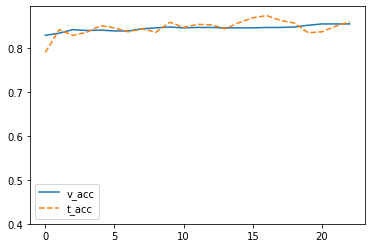

In [ ]:
plt.plot(v_acc)
plt.plot(t_acc, linestyle = '--')
plt.legend(['v_acc', 't_acc'])
plt.ylim(0.40, 0.895)

plt.show()